In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# 
For vpsc runs by vpsc_yield.py, plot each VPSC yield surface, try to fit a Hill surface.

In [2]:
def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

def plot_on_yield_triangle(ax, max_r):
    """Add the prinipal stress axes to a pi-plane plot
    Input an axis object and the radius of the prinical stress axes
    """
    s11 = pol2cart(max_r, 210.*np.pi/180.)
    s22 = pol2cart(max_r, 330.*np.pi/180.)
    s33 = pol2cart(max_r, 90.*np.pi/180.)
    ax.plot([0,s11[0]], [0,s11[1]], 'k')
    ax.plot([0,s22[0]], [0,s22[1]], 'k')
    ax.plot([0,s33[0]], [0,s33[1]], 'k')
    ax.annotate('$\sigma_{11}$',(s11[0], s11[1]-max_r*.1))
    ax.annotate('$\sigma_{22}$',(s22[0]-max_r*.1, s22[1]-max_r*.1))
    ax.annotate('$\sigma_{33}$',(s33[0]+max_r*.05, s33[1]-max_r*.05))


def tensor_from_voigt(v, off_axis_correction=False):
    if isinstance(v, np.ndarray) == False:
        v = np.array(v)
    assert v.size == 6
    if off_axis_correction == True:
        v[3] *= 0.5
        v[4] *= 0.5
        v[5] *= 0.5
    m = np.array( [[ v[0], v[5], v[4]  ],
                  [  v[5], v[1], v[3] ],
                  [  v[4], v[3], v[2] ] ])
    return m

def voigt_vector(a):
    if isinstance(a, np.ndarray) == False:
        a = np.array(a)
    assert a.shape[0] == 3
    assert a.shape[1] == 3
    return np.transpose(np.array([a[0,0], a[1,1], a[2,2],
        a[1,2], a[0,2], a[0,1]]))


------------------- BEGIN RUN -------------------


/var/folders/qq/lxwp07wd1sd8k0p3n720xpbr0000gn/T/ipykernel_74249/3519140890.py:48: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  vpsc_data = pd.read_csv(f'PCYS.OUT', delim_whitespace=True, skiprows=lambda x: x not in rows_to_read)
/var/folders/qq/lxwp07wd1sd8k0p3n720xpbr0000gn/T/ipykernel_74249/3519140890.py:48: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  vpsc_data = pd.read_csv(f'PCYS.OUT', delim_whitespace=True, skiprows=lambda x: x not in rows_to_read)
/var/folders/qq/lxwp07wd1sd8k0p3n720xpbr0000gn/T/ipykernel_74249/3519140890.py:48: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  vpsc_data = pd.read_csv(f'PCYS.OUT', delim_whitespace=True, skiprows=lambda x: x not in rows_to_read)
/var/folders/

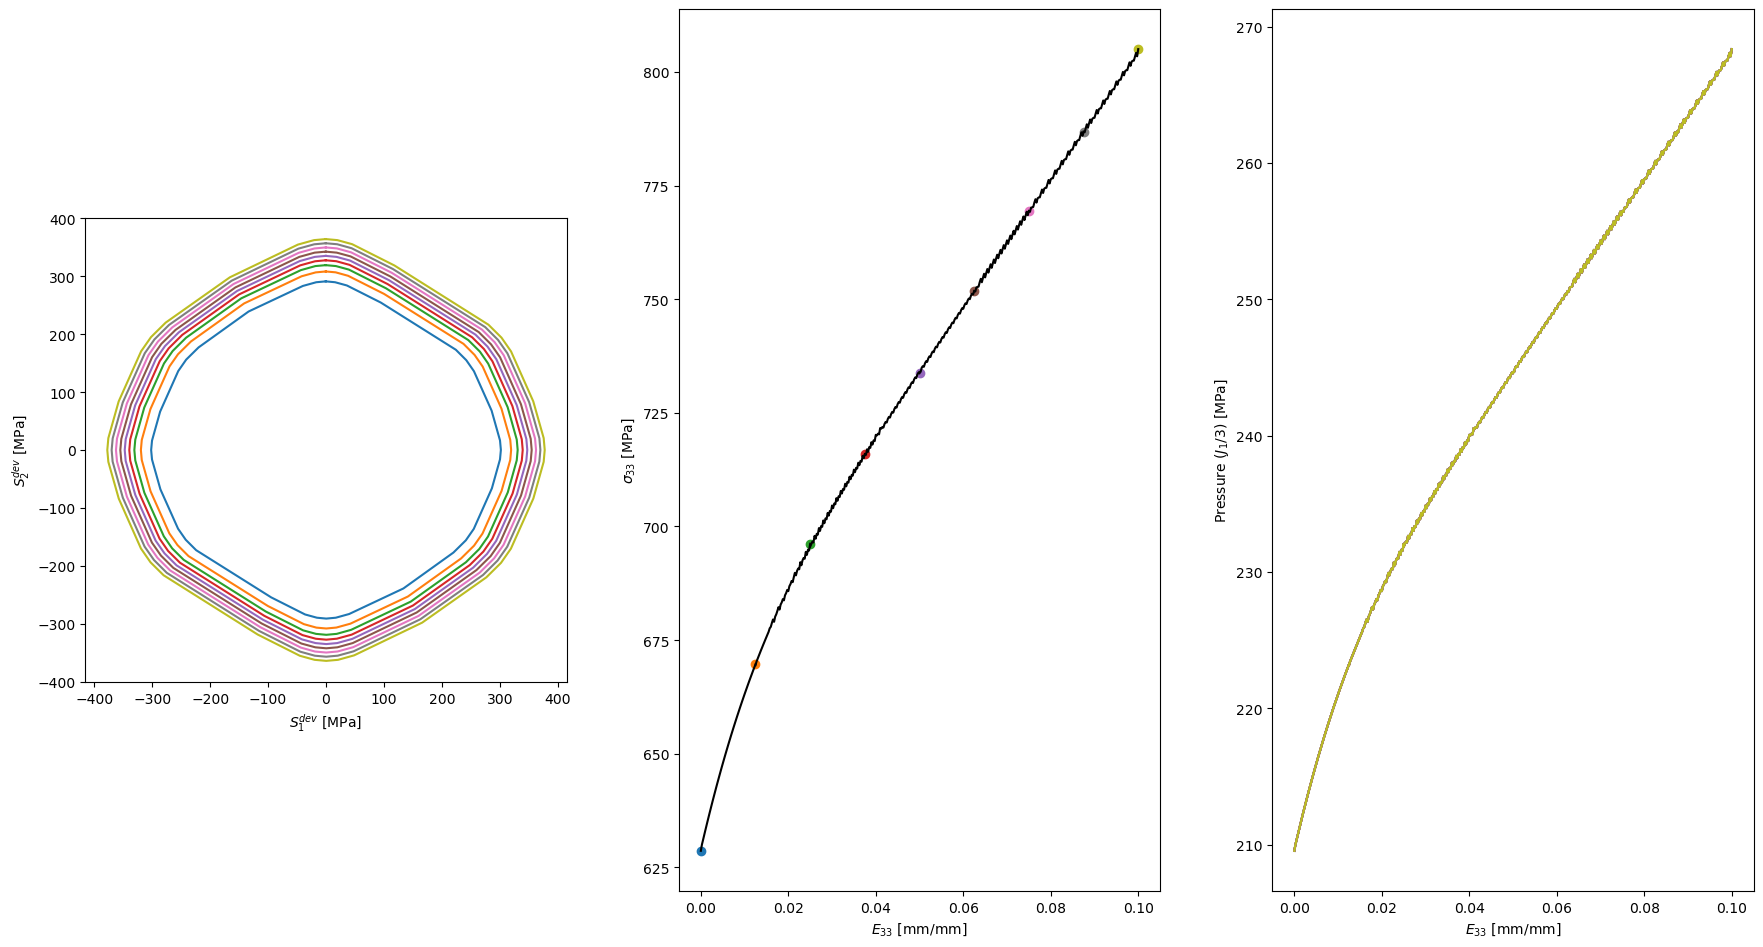

In [3]:

print(f'------------------- BEGIN RUN -------------------')


pcys_file = open(f'PCYS.OUT', 'r')
sections = []
lines_in_file = None
for i, line in enumerate(pcys_file):
    if line.strip().startswith('S1'):
        sections.append(i)
    lines_in_file = i + 1 

pcys_file.close()

ss_file = open(f'STR_STR.OUT', 'r')
strain_sections = []
stress_sections = []

stress_tensors = []
strain_voigt_vectors = []

# Break the stress strain output into lists
for i, line in enumerate(ss_file):
    if line.strip().startswith('Evm'):
        strain_sections.append([])
        stress_sections.append([])
    else:
        line = line.strip().split()
        strain_sections[-1].append(float(line[4])) # E33
        stress_sections[-1].append(float(line[10])) # Scau 33
        strain_voigt_vectors.append([ float(line[f]) for f in range(2,8)  ] )
        stress_tensors.append(np.array( tensor_from_voigt( [ float(line[f]) for f in range(8,14)  ] ) ))

pressures = [ 1./3.*np.trace(s) for s in stress_tensors ]

ss_file.close()

fig, axs = plt.subplots(1,3)

fig.set_size_inches(18.5, 10.5)
fig.tight_layout(pad=5.0)
ax = axs[0]


for i, sec in enumerate(sections):
    rows_to_read = range(sec, lines_in_file) if i == (len(sections) - 1) else range(sec, sections[i+1])
    #print(rows_to_read)

    vpsc_data = pd.read_csv(f'PCYS.OUT', delim_whitespace=True, skiprows=lambda x: x not in rows_to_read)
    texture = np.loadtxt(f'texture.tex', delimiter=" ", skiprows=4)
            
    # Plot the vpsc output
    vpsc_data.plot(x='S1', y='S2', ax=ax, label=f'VPSC{i}', legend=False)

    if i == 0:
        axs[1].plot(strain_sections[i][0], stress_sections[i][0], 'o')
    else:
        axs[1].plot(strain_sections[i-1][-1], stress_sections[i-1][-1], 'o')
    if i != 0:
        axs[1].plot(strain_sections[i-1], stress_sections[i-1], 'k')

    # Plot the pressures as a function of E33
    axs[2].plot([ e[2] for e in strain_voigt_vectors ] , pressures)
    

ax.set_ylabel('$S^{dev}_2$ [MPa]')
ax.set_xlabel('$S^{dev}_1$ [MPa]')
ax.set_aspect('equal', adjustable='box')
#ax.legend(loc='best')

axs[1].set_xlabel('$E_{33}$ [mm/mm]')
axs[1].set_ylabel('$\sigma_{33}$ [MPa]')

axs[2].set_xlabel('$E_{33}$ [mm/mm]')
axs[2].set_ylabel('Pressure ($J_1$/3) [MPa]')


# Do some sanity checks

# # Test 1: Check that the Deviatoric Stress Matches what we see
# last_cauchy = stress_tensors[-1]
# devatioric_stress = last_cauchy - pressures[-1]*np.eye(3)
# normalized_deviatoric_stress = tensor_from_voigt(voigt_vector(devatioric_stress)/np.linalg.norm(voigt_vector(devatioric_stress)))


# J2 = 0.5*np.einsum('ij,ji', normalized_deviatoric_stress, normalized_deviatoric_stress)
# J3 = np.linalg.det(normalized_deviatoric_stress)
# theta = np.arccos( 3*np.sqrt(3.)/2. * J3/J2**(3./2.) )/3.
# r = np.sqrt(2*J2)
# sanity_point = pol2cart(r, theta)


# print(sanity_point)
# ax.plot(sanity_point[0], sanity_point[1], 'ko')

plt.show()
